# Bayesian Machine Learning project

## MCGdiff for gaussian mixture models

In [7]:
import torch 
from torch.distributions.chi2 import Chi2
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [42]:
class GaussianMixtureModel() :
    def __init__(self, sigma=1.) :
        self.sigma = sigma
        self.centers = torch.Tensor([[8*i, 8*j] for i in [-2, -1, 0, 1, 2] for j in [-2, -1, 0, 1, 2]])
        chi2 = Chi2(torch.ones(25))
        omegas = chi2.sample()
        self.weights = omegas/torch.sum(omegas)

    def sample(self, n_sample=1000):
        indices = torch.multinomial(self.weights, num_samples=n_sample, replacement=True)
        sample = self.centers[indices] + torch.randn(n_sample, 2)*self.sigma
        return sample
    
    def measure(self, n_sample) :
        """
        inpainting measure
        """
        x = self.sample(n_sample)
        y = x[:,0] #+ torch.randn(n_sample)*noise
        return y
        
    def posterior_sampling(self, y):
        """
        y is a measure of the first component of x
        """
        n = len(y)
        x = torch.zeros(n, 2)
        new_weights = self.weights[:,None]*torch.exp(-(y[None,:]-self.centers[:,0][:,None])**2/2) 
        idx = torch.multinomial(new_weights.T, 1).squeeze(1)
        x_estimate = self.centers[idx] + torch.randn(n, 2)*self.sigma
        x[:,0] = y
        x[:,1] = x_estimate[:,1]
        return x

In [43]:
n_sample = 10_000
gmm = GaussianMixtureModel()

In [44]:
X = gmm.sample(n_sample=n_sample)

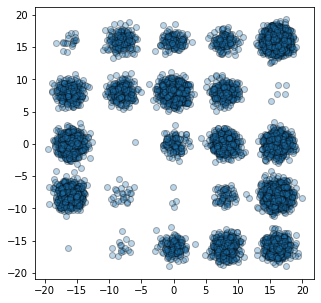

In [45]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], edgecolor="k", alpha=0.3)
plt.show()

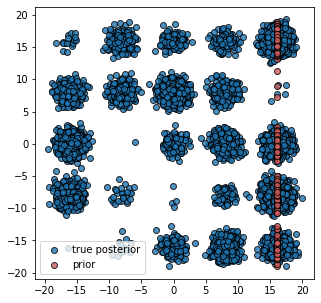

In [49]:
y = 16*torch.ones(1000) #gmm.measure(1000)
x = gmm.posterior_sampling(y)
fig = plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], edgecolor="k", alpha=0.8)
plt.scatter(x[:,0], x[:,1], edgecolor="k", alpha=0.8, color="indianred")
plt.legend(["true posterior", "prior"])
plt.show()

## Denoising diffusion model

### Forward process 

A diffusion models can be seen as an encoder-decoder architecture. The forward process consist to add iteratively a small amount of noise to the data or the image. It writes : 

$$ x_{t+1} \mid x_t \sim \mathcal{N}(x_{t+1} ; \sqrt{1-\beta_t}x_t, \beta_t I)$$

### Backward process

The decoder can sample a new image or data from the latent space thanks to the score function $s_{\theta}$, whichi is typically a U-Net and $\theta$ are the parameters which can be learned. The backward process writes : 

$$ x_{t} \mid x_{t+1} \sim \mathcal{N}\left(x_{t} ; \frac{1}{\sqrt{\alpha_{t+1}}}\left(x_{t+1} + \beta_{t+1} s_{\theta}(x_{t+1}, t+1)\right), \beta_{t+1} I\right)$$

### Monte Carlo guided diffusion for Gaussian Mixture Models

In [13]:
def build_extended_svd(A: torch.tensor):
    U, d, V = torch.linalg.svd(A, full_matrices=True)
    coordinate_mask = torch.ones_like(V[0])
    coordinate_mask[len(d):] = 0
    return U, d, coordinate_mask, V

In [14]:
def log_normal(x, m, sigma2):
    return -torch.sum((x - m)**2, axis=-1) / (2*sigma2) - .5*torch.log(sigma2)

In [90]:
class ExactScoreMatching():
    def __init__(self, beta_start=1e-4, beta_end=0.2, num_steps=200):
        self.num_steps = num_steps
        self.betas = torch.linspace(beta_start, beta_end, num_steps)
        
        self.alphas = 1 - self.betas
        self.cum_alphas = torch.ones(num_steps+1)
        self.cum_alphas[1:] = torch.cumprod(self.alphas, dim=0)
        self.t = torch.linspace(0, 1, num_steps)
        self.gmm = GaussianMixtureModel()

    def log_prob(self, x, i) :                           
        weights, means, sigma = self.gmm.weights, torch.sqrt(self.cum_alphas[i])*self.gmm.centers, self.gmm.sigma       
         
        y = x[:, None] - means[None, :]    
        log_p = torch.log(weights[None, :]) - torch.sum(y**2, axis=-1) / (2*sigma**2)
        return torch.logsumexp(log_p, dim=-1)

    def score(self, x, i):
        outputs = self.log_prob(x, i).sum()
        grad = torch.autograd.grad(outputs, x)
        return grad[0]

    def forward(self, x0):
        xi = torch.clone(x0)
        x_seq = [xi]
        for i, beta in enumerate(self.betas) :
            z = torch.randn(x0.shape)
            xi = torch.sqrt(1 - beta)*xi + torch.sqrt(beta)*z 
            x_seq.append(xi)
        return x_seq

    def backward(self, xT):
        x_i = torch.clone(xT)
        x_seq = [x_i]
        times = torch.arange(self.num_steps-1, 0, step=-1)
        for i in tqdm(times):
            x_i.requires_grad_(True)
            s_i = self.score(x_i, i)
            with torch.no_grad():  
                mu_i = 1/torch.sqrt(self.alphas[i]) * (x_i + self.betas[i] * s_i)
                x_i = mu_i + torch.sqrt(self.betas[i])*torch.randn(xT.shape)
                x_seq.append(x_i)
        return x_seq
    
    def MCGdiff(self, A, y, mask_idx, obs_idx, n_particles=10):
        """
        Posterior sampling using MCGdiff algorithm
        """
        U, d, _, VT = build_extended_svd(A)
        U = U.float()
        d = d.float()
        Y = torch.diag(d**-1) @ U.T @ y
        VT = VT.float()
        V = VT.T
        dx = len(mask_idx) + len(obs_idx)
        z = torch.randn(n_particles, dx)
        K = (self.betas[1:] / (self.betas[1:] + 1 - self.alphas[:-1]))
        Xi = torch.zeros(n_particles, dx)
        Xi[:,obs_idx] = K[-1]*torch.sqrt(self.cum_alphas[-1])*Y + (1 - self.cum_alphas[-1])*K[-1]*z[:,obs_idx]
        Xi[:,mask_idx] =  z[:,mask_idx]
        
        # Vrep = V.repeat(len(self.gmm.centers), 1, 1)
        # print(V)
        # self.gmm.centers = torch.bmm(Vrep, self.gmm.centers[:,:,None]).squeeze(-1)
        
        Xi.requires_grad_(True)
        times = torch.arange(self.num_steps-2, 0, step=-1)
        Xi_seq = [Xi]
        for i in tqdm(times):
            Xi.requires_grad_(True)
            s_i = self.score(Xi, i+1)
            with torch.no_grad():  
                Xi = Xi.detach()
                m = 1/torch.sqrt(self.alphas[i+1]) * (Xi + self.betas[i+1] * s_i)
                if i==self.num_steps-2:
                    log_omegas = log_normal(self.cum_alphas[i+1]**.5*Y[None,:], m[:,obs_idx], 2 - self.cum_alphas[i+1])
                else :
                    log_omegas = log_normal(self.cum_alphas[i]**.5*Y[None,:], m[:,obs_idx], self.betas[i+1] + 1 - self.cum_alphas[i]) \
                    - log_normal(self.cum_alphas[i+1]**.5*Y[None,:], m[:,obs_idx], 1 - self.cum_alphas[i+1])
                z = torch.randn(n_particles, dx)
                # RESAMPLING
                prob = torch.exp(log_omegas - torch.logsumexp(log_omegas, axis=-1))
                I = torch.multinomial(prob, n_particles, replacement=True)
                
                #m = m[I]
                Xi = torch.zeros(n_particles, dx)
                Xi[:,obs_idx] = K[i]*self.cum_alphas[i]**.5*Y + (1-K[i])*m[:, obs_idx] + (1-self.cum_alphas[i])**.5*K[i]**.5*z[:,obs_idx]
                Xi[:,mask_idx] = m[:,mask_idx] + torch.sqrt(self.betas[i])*z[:,mask_idx]
                Xi = Xi[I]
                V_Xi = torch.bmm(V.repeat(len(Xi), 1, 1), Xi[:,:,None]).squeeze(-1)
                Xi_seq.append(V_Xi)
            
        return Xi_seq

In [91]:
def log_prob(x, gmm, V=None) :                           
    weights, means, sigma = gmm.weights, gmm.centers, gmm.sigma       
         
    if V is not None :
        Vrep = V.repeat(len(means), 1, 1)
        means = torch.bmm(Vrep, means[:,:,None]).squeeze(-1)
    y = x[:, None] - means[None, :]    

    log_p = torch.log(weights[None, :]) - torch.sum(y**2, axis=-1) / (2*sigma**2)
    return torch.logsumexp(log_p, dim=-1)

def score(x, gmm, V=None):
    x.requires_grad_(True)
    outputs = log_prob(x, gmm, V).sum()
    grad = torch.autograd.grad(outputs, x)
    print(grad)
    return grad[0]

In [86]:
gmm = GaussianMixtureModel()

In [87]:
A = torch.linspace(20, -20, 200)
B = torch.linspace(-20, 20, 200)
T = torch.zeros((200, 200))
for i, y in enumerate(A) :
    for j, x in enumerate(B) :
        T[i, j] = log_prob(torch.Tensor([[x, y]]), gmm, V=None)

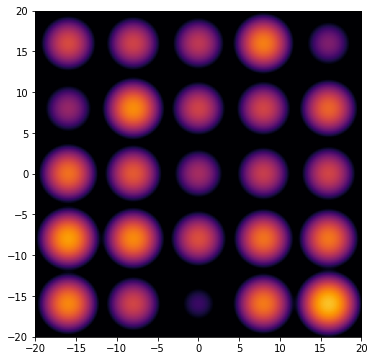

In [88]:
fig = plt.figure(figsize=(6, 6))
#X = esm.gmm.sample(n_sample=n_sample)
#plt.scatter(X[:,0], X[:,1], edgecolor="k", alpha=0.3)

plt.imshow(T, cmap="inferno", vmin=-10, vmax=0, extent=[-20, 20, -20, 20])

In [23]:
torch.manual_seed(0)
N = 1000
esm = ExactScoreMatching(num_steps=N)
X = esm.gmm.sample(n_sample=n_sample)
x_forward = esm.forward(X)

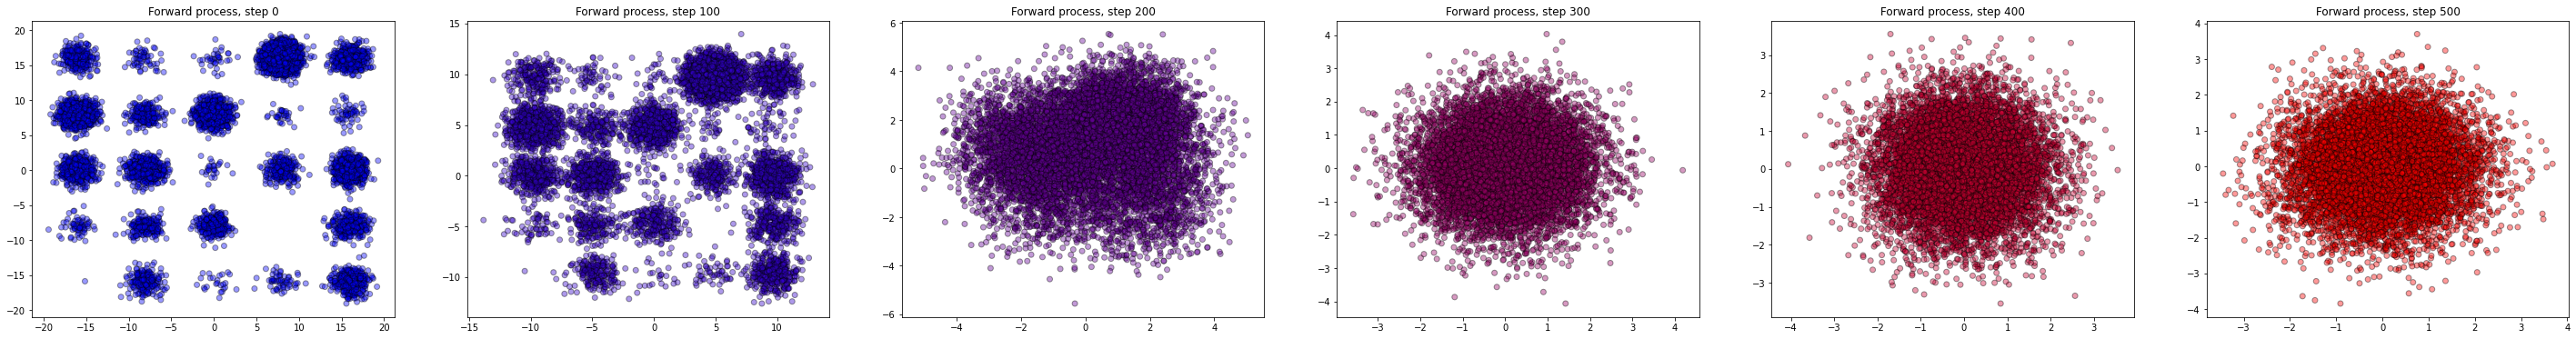

In [24]:
n_display = 6
idx = torch.arange(0, N, step=100)
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(50, 6))
for i in range(n_display) :
    c = [[s[i], 0, 1-s[i], 0.75] for _ in range(n_sample)]
    ax[i].scatter(x_forward[idx[i]][:,0], x_forward[idx[i]][:,1], edgecolor="k", c=c, alpha=0.4)
    ax[i].set_title("Forward process, step {}".format(idx[i]))
plt.show()

In [25]:
x_seq = esm.backward(x_forward[-1])

100%|████████████████████████████████████████| 999/999 [00:04<00:00, 219.48it/s]


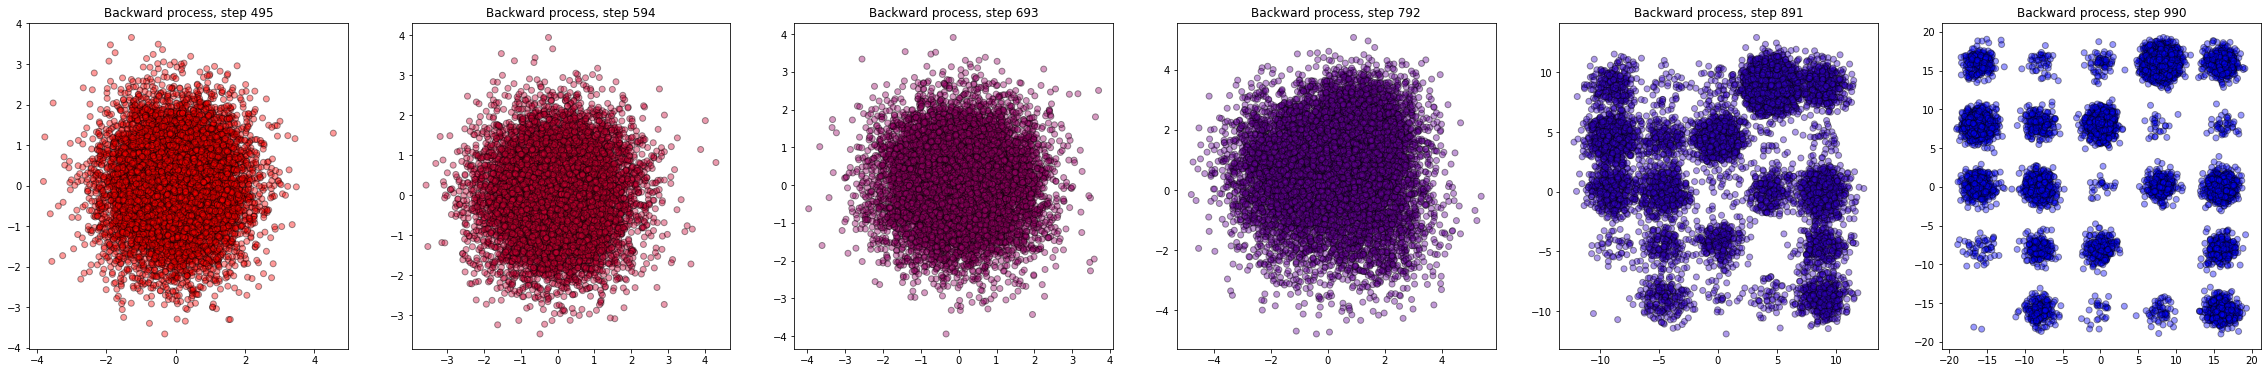

In [26]:
n_display = 6
idx = torch.arange(0, N, step=99)
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(40, 6))
for i in range(n_display) :
    c = [[s[i], 0, 1-s[i], 0.75] for _ in range(n_sample)]
    ax[-i-1].scatter(x_seq[idx[-i-1]][:,0].detach(), x_seq[idx[-i-1]][:,1].detach(), edgecolor="k", c=c, alpha=0.4)
    ax[-i-1].set_title("Backward process, step {}".format(idx[-i-1]))
plt.show()

In [170]:
y = torch.tensor([16.])
#torch.manual_seed(0)
N = 1000
esm = ExactScoreMatching(num_steps=N)
X = esm.gmm.sample(n_sample=10_000)
A = torch.Tensor([[2, -1]]).float()
A = torch.Tensor([[1, -1]]).float()
A = torch.Tensor([[1, 0]]).float()

x = esm.gmm.posterior_sampling(y)
y = torch.tensor([16.])
Xi = esm.MCGdiff(A, y, [1], [0], n_particles=4_000)

100%|████████████████████████████████████████| 998/998 [00:02<00:00, 354.84it/s]


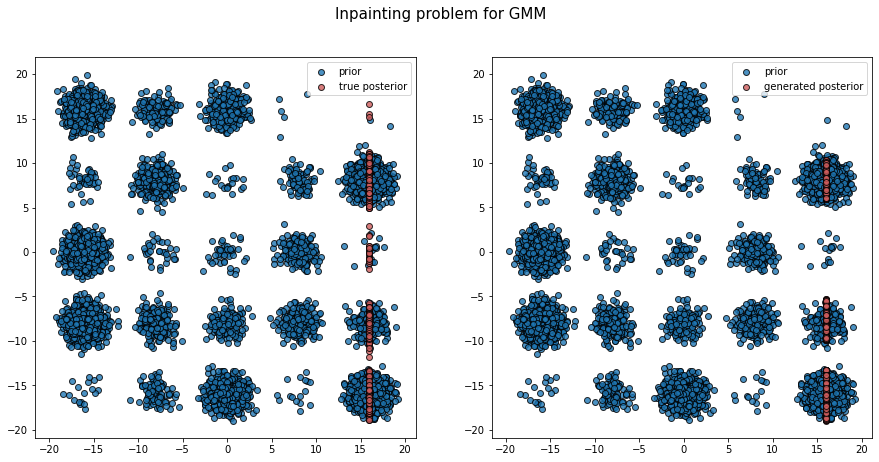

In [171]:
y = 16*torch.ones(4000) #gmm.measure(1000)
x = esm.gmm.posterior_sampling(y)
fig, ax = plt.subplots(ncols = 2, figsize=(15, 7))

ax[0].scatter(X[:,0], X[:,1], edgecolor="k", alpha=0.8)
ax[0].scatter(x[:,0], x[:,1], edgecolor="k", alpha=0.8, color="indianred")
ax[0].legend(["prior", "true posterior"])

ax[1].scatter(X[:,0], X[:,1], edgecolor="k", alpha=0.8)
ax[1].scatter(Xi[-1][:,0], Xi[-1][:,1], edgecolor="k", alpha=0.8, color="indianred")
ax[1].legend(["prior", "generated posterior"])

plt.suptitle("Inpainting problem for GMM", fontsize=15)
plt.savefig("inpainting_gmm.png")
plt.show()

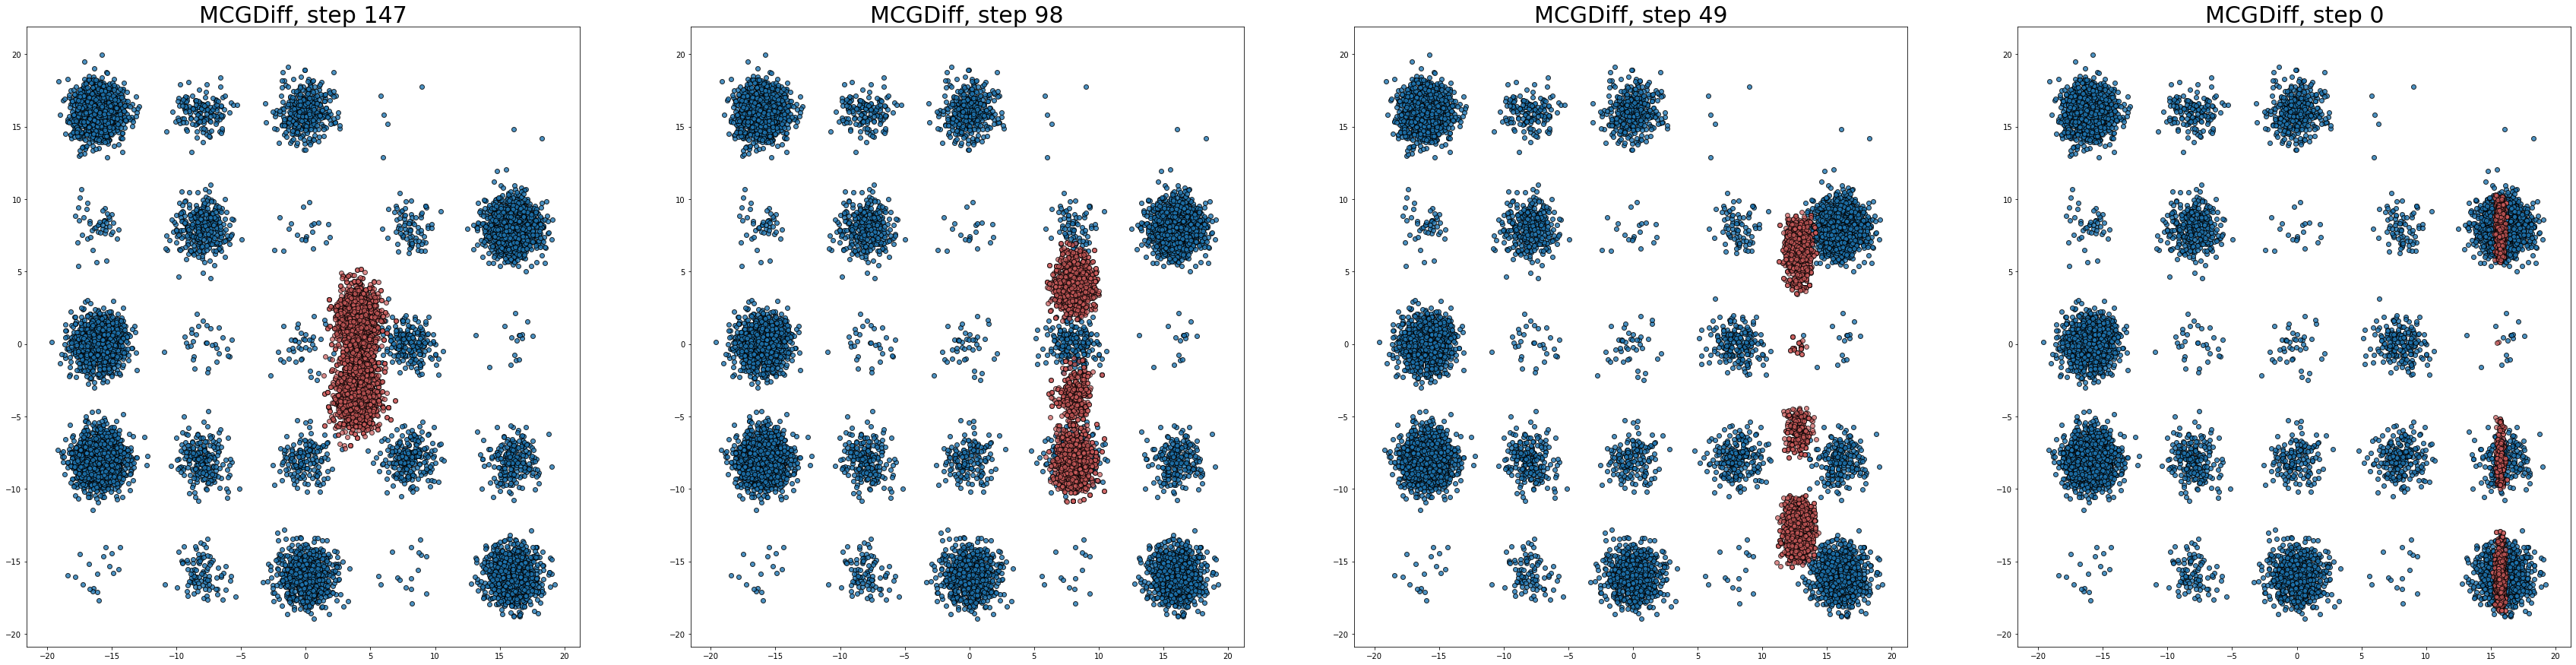

In [172]:
n_display = 4
idx = torch.arange(0, N, step=49)
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(60, 15))

for i in range(n_display) :
    c = [[s[i], 0, 1-s[i], 0.75] for _ in range(len(Xi[-1]))]
    ax[-i-1].scatter(X[:,0].detach(), X[:,1].detach(), alpha=0.8, edgecolor="k")
    ax[-i-1].scatter(Xi[idx[-i-1]][:,0].detach(), Xi[idx[-i-1]][:,1].detach(), edgecolor="k", c="indianred", alpha=0.7)
    ax[-i-1].set_title("MCGDiff, step {}".format(idx[i]), fontsize=30)
plt.show()

In [156]:
#torch.manual_seed(42)
N = 1000
esm = ExactScoreMatching(num_steps=N)

X = esm.gmm.sample(n_sample=10_000)
A = torch.Tensor([[2, -1]]).float()
A = torch.Tensor([[1, -1]]).float()
U, d, _, VT = build_extended_svd(A)
V = VT.T

Vrep = VT.repeat(len(esm.gmm.centers), 1, 1)
esm.gmm.centers = torch.bmm(Vrep, esm.gmm.centers[:,:,None]).squeeze(-1)
y = torch.tensor([0.])
Xi = esm.MCGdiff(A, y, [1], [0], n_particles=4000)

100%|████████████████████████████████████████| 998/998 [00:02<00:00, 341.79it/s]


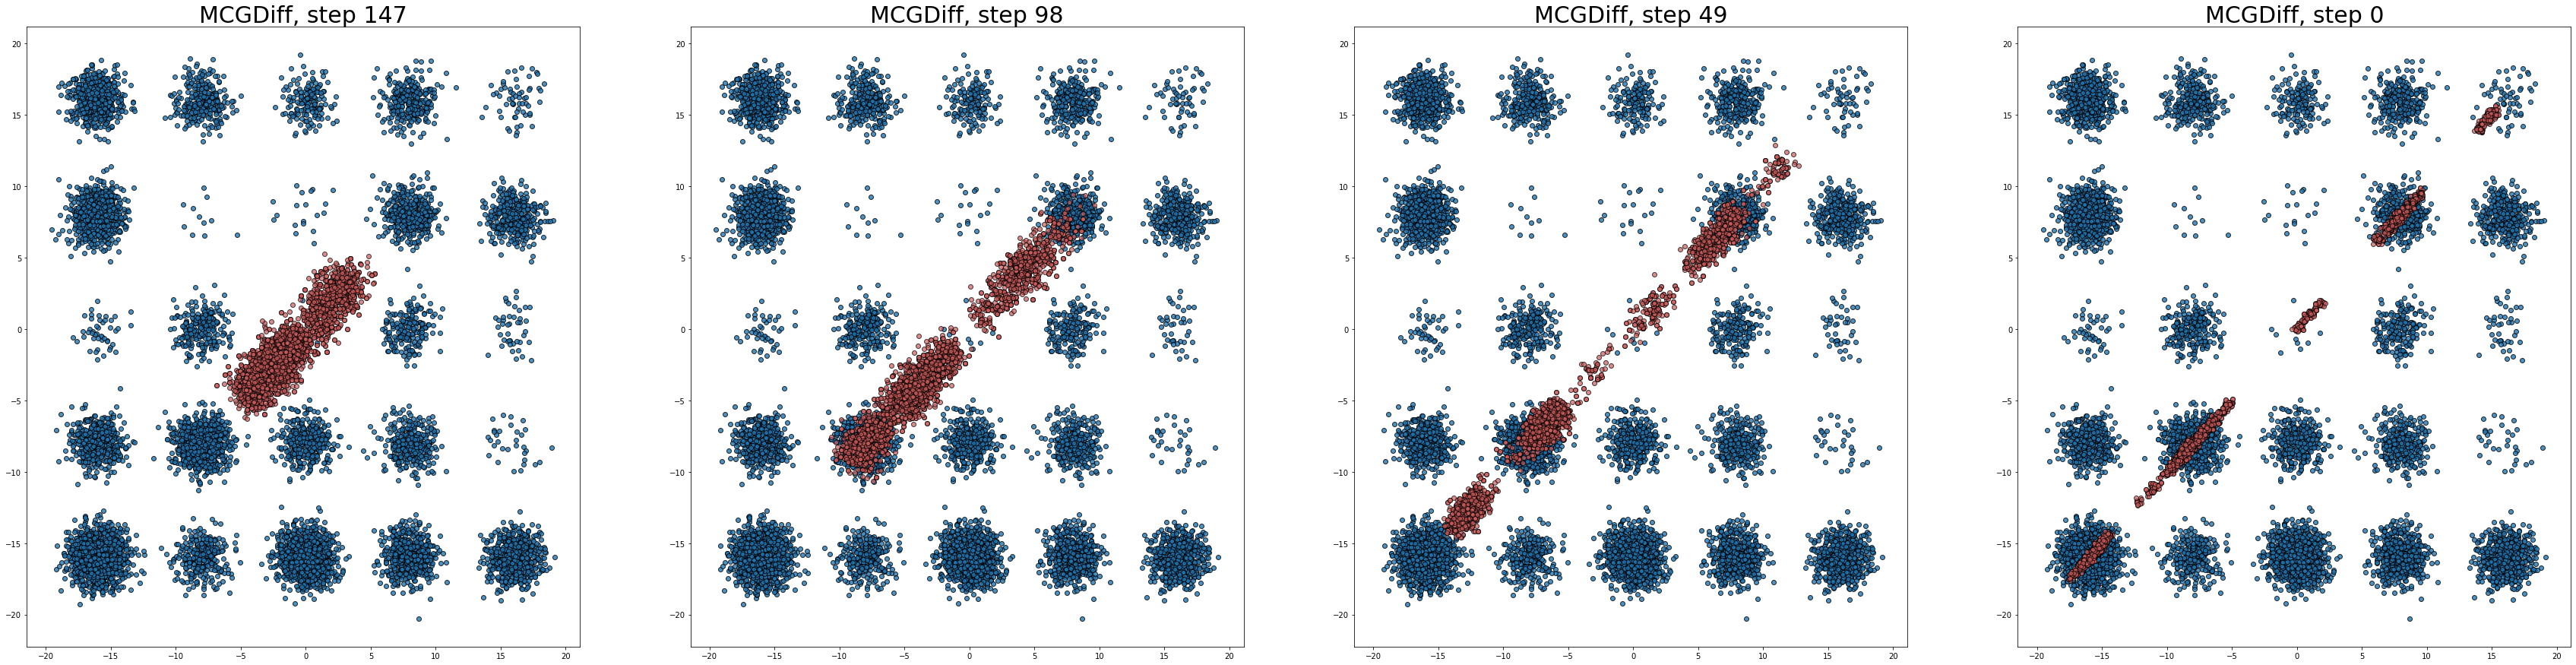

In [157]:
n_display = 4
idx = torch.arange(0, N, step=49)
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(60, 15))
#VX = torch.bmm(VT.repeat(len(X), 1, 1), X[:,:,None]).squeeze(-1)

for i in range(n_display) :
    c = [[s[i], 0, 1-s[i], 0.75] for _ in range(len(Xi[-1]))]
    ax[-i-1].scatter(X[:,0].detach(), X[:,1].detach(), alpha=0.8, edgecolor="k")
    ax[-i-1].scatter(Xi[idx[-i-1]][:,0].detach(), Xi[idx[-i-1]][:,1].detach(), edgecolor="k", c="indianred", alpha=0.7)
    ax[-i-1].set_title("MCGDiff, step {}".format(idx[i]), fontsize=30)
plt.show()